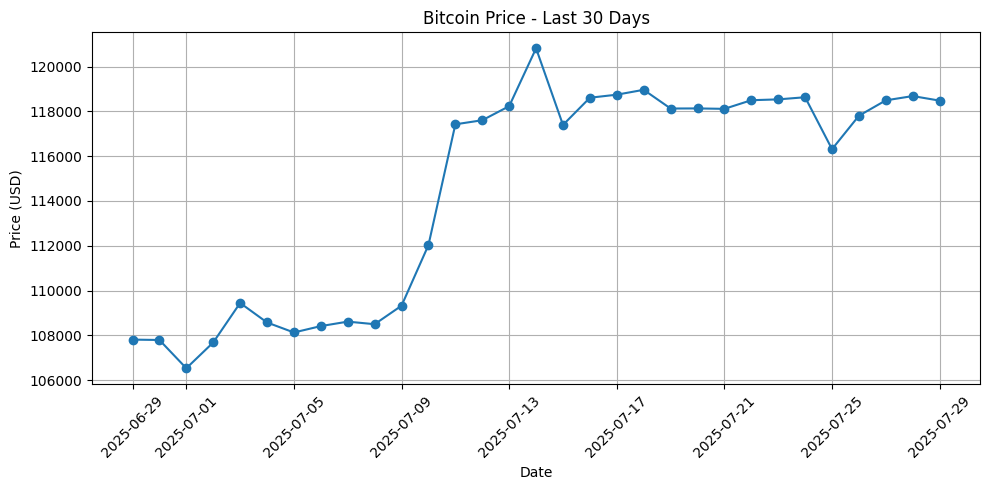


📄 Report:

Error generating report: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************e-kA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import openai
import datetime
from google.colab import userdata

# --- Config ---
ASSET = "bitcoin"  # or stock like 'AAPL'
CURRENCY = "usd"
DAYS = 30
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# --- Fetch Historical Data from CoinGecko (Crypto) ---
def fetch_crypto_prices(coin='bitcoin', currency='usd', days=30):
    url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
    params = {'vs_currency': currency, 'days': days}
    res = requests.get(url, params=params)
    data = res.json()

    prices = data['prices']
    df = pd.DataFrame(prices, columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit='ms').dt.date
    df = df.groupby("date").mean().reset_index()
    return df

# --- Plot Price Trend ---
def plot_prices(df, title="Price Trend"):
    plt.figure(figsize=(10, 5))
    plt.plot(df["date"], df["price"], marker='o')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("trend.png")
    plt.show()

# --- Generate Plain-English Report using OpenAI ---
def generate_report(df):
    price_change = df["price"].iloc[-1] - df["price"].iloc[0]
    percent_change = (price_change / df["price"].iloc[0]) * 100
    trend_summary = f"The price of {ASSET} changed by {percent_change:.2f}% over the last {DAYS} days."

    client = openai.OpenAI(api_key=OPENAI_API_KEY)
    prompt = (
        f"{trend_summary}\n"
        f"Here are some insights based on this data:\n"
        f"1. What might be the reason for this trend?\n"
        f"2. Should an average investor consider buying, holding, or selling?\n"
        f"Please explain in simple English."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "user", "content": prompt}
            ],
            max_tokens=300
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error generating report: {e}"


# --- Run Everything ---
if __name__ == "__main__":
    data = fetch_crypto_prices(ASSET, CURRENCY, DAYS)
    plot_prices(data, f"{ASSET.capitalize()} Price - Last {DAYS} Days")
    report = generate_report(data)
    print("\n📄 Report:\n")
    print(report)